In [8]:
!pip install --upgrade imbalanced-learn==0.10.1
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [9]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value) 

In [10]:

IMG_SIZE = (256, 256)  
BATCH_SIZE = 16
EPOCHS = 100
data_dir = "/kaggle/input/ppmi-3/MRI-CONV--v1"
classes = ["NONPD", "PD"]

X, y = [], []
for idx, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
        X.append(img)
        y.append(idx)

X = np.array(X) / 255.0
y = np.array(y)

In [11]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [12]:
nsamples, nx, ny, nch = X_train.shape
X_train_flat = X_train.reshape((nsamples, nx*ny*nch))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train)
X_train_res = X_train_res.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)

y_train_res_cat = to_categorical(y_train_res, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  


I0000 00:00:1761485554.131517      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761485554.132263      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model = models.Sequential([
    base_model,

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,958,882 (64.69 MB)

 Trainable params: 2,242,210 (8.55 MB)

 Non-trainable params: 14,716,672 (56.14 MB)

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [16]:
history = model.fit(
    X_train_res, y_train_res_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100


2025-10-26 13:32:39.945212: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1761485566.103222     142 cuda_dnn.cc:529] Loaded cuDNN version 90300


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6322 - loss: 1.3121

2025-10-26 13:32:55.770920: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.6329 - loss: 1.3077 - val_accuracy: 0.3037 - val_loss: 0.7190
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.7915 - loss: 0.5023 - val_accuracy: 0.2757 - val_loss: 0.9142
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8938 - loss: 0.2684 - val_accuracy: 0.4766 - val_loss: 0.8201
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9260 - loss: 0.1813 - val_accuracy: 0.6776 - val_loss: 0.6675
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9420 - loss: 0.1216 - val_accuracy: 0.6495 - val_loss: 0.9296
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9680 - loss: 0.0804 - val_accuracy: 0.7290 - val_loss: 0.6613
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.9867 - loss: 0.0570 - val_accuracy: 0.7991 - val_loss: 0.6271
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9874 - loss: 0.0349 - val_accuracy: 0.8084 - va

2025-10-26 13:35:09.771900: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step

Classification Report:

              precision    recall  f1-score   support

       NONPD       0.58      0.72      0.64        54
          PD       0.90      0.82      0.86       160

    accuracy                           0.80       214
   macro avg       0.74      0.77      0.75       214
weighted avg       0.82      0.80      0.81       214



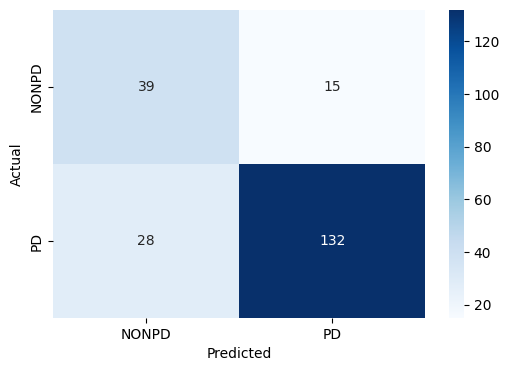

In [17]:
 y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=classes))
 
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"\nModel Performance Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")


Model Performance Metrics:
Accuracy  : 0.7991
Precision : 0.8183
Recall    : 0.7991
F1 Score  : 0.8056
